In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Titanic:  Predicting Survival

In [6]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## 1. Load the data    

In [7]:
#load data and look at the features
titanic_df = pd.read_csv('~/Documents/Data_Science_Training/Kaggle_Projects/Titanic/train.csv',)

df = deepcopy(titanic_df)

#change index to passengerId
df = df.set_index('PassengerId')

df.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


### a. Describe Data

In [8]:
print('Number of passengers:',df.shape[0])
print('Number of features:', df.shape[1])

print('Number of passengers survived: ',str(sum(df['Survived'])))
print('Number of passengers did not survive: ',str(sum(df['Survived']==0)))

df.describe()

Number of passengers: 891
Number of features: 11
Number of passengers survived:  342
Number of passengers did not survive:  549


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### b. Missing Data Count


In [9]:
#Count the number of missing values in the dataset
print(df.isnull().sum())


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


## 2. Create New Features

Use existing features to create new features in the data.

### a. Family Size

Having separate categories for Siblings and Spouses and Parents and Children is not as helpful.  Combine them into one column.

In [10]:
#Add SibSp and Parch to see if there is a relationship between family size and survivability.  

def createFamSize(dataframe):
    famsize = dataframe['Parch']+dataframe['SibSp']
    dataframe['familySize'] = famsize

createFamSize(df)

### b. Is Alone
It may be more useful to have a feature signifying if a person is traveling alone instead of the family size

In [11]:
#create new categorical feature: is alone.  0 means with family and 1 means alone

def createIsAlone(dataframe): 
    dataframe['isAlone'] = np.where(dataframe['familySize'] >= 1, 0, 1)

createIsAlone(df)

### c. Title 
Extract the title from the passenger's name.  The rare titles will be grouped together in a 'rare' category.

In [12]:
# strip the title from their name and create new feature

def createTitle(dataframe):
    removeLastName = dataframe['Name'].str.split(',').str[1]
    dataframe['title'] = removeLastName.str.split(' ').str[1]

    # count unique titles
    titles = dataframe['title'].value_counts()
    #print(titles)

    #update titles into rare category
    dataframe['title'].replace(['Ms.','Mlle.'], 'Miss.', inplace = True)
    dataframe['title'].replace(['Lady.','Mme.'], 'Mrs.', inplace = True)
    dataframe['title'].replace(['Sir.'], 'Mr.', inplace = True)
    #allowed titles
    title_cats = ['Miss.', 'Mr.', 'Mrs.', 'Master.']

    dataframe['title'].loc[~dataframe['title'].isin(title_cats)] = 'Rare.'

    #check updated counts
    print(dataframe['title'].value_counts())

createTitle(df)

Mr.        518
Miss.      185
Mrs.       127
Master.     40
Rare.       21
Name: title, dtype: int64


## 3. Survivability Plots
Create plots to look at relationships between survivability and the features.  From the data it looks like class, gender, and age will be important features in determining survivability. 


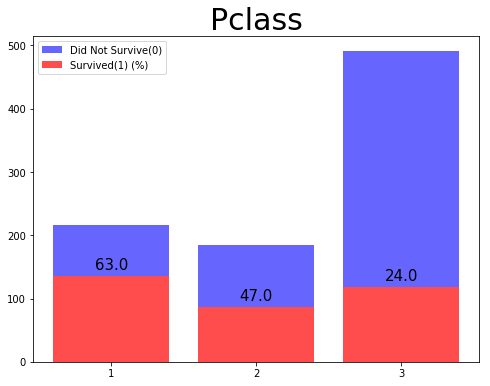

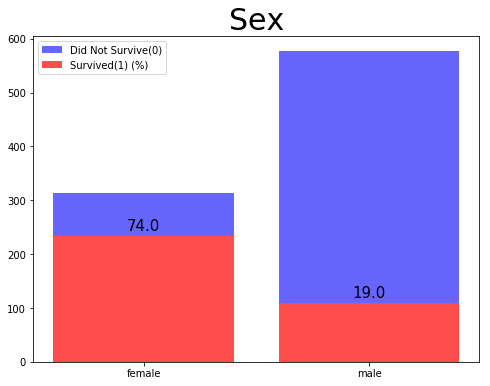

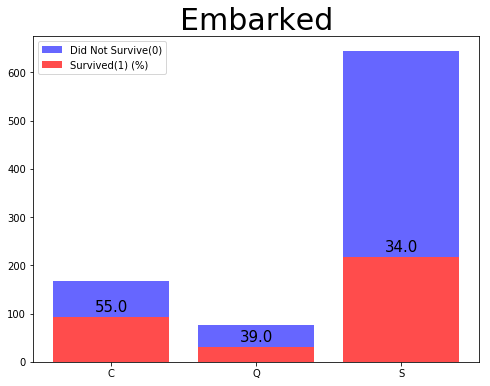

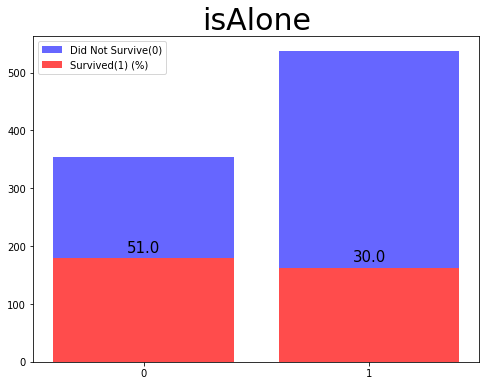

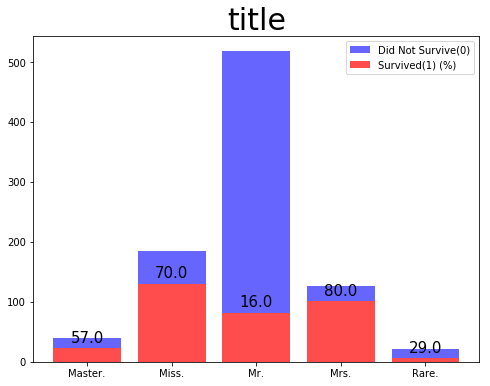

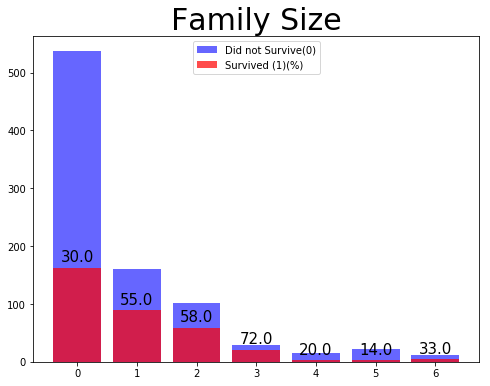

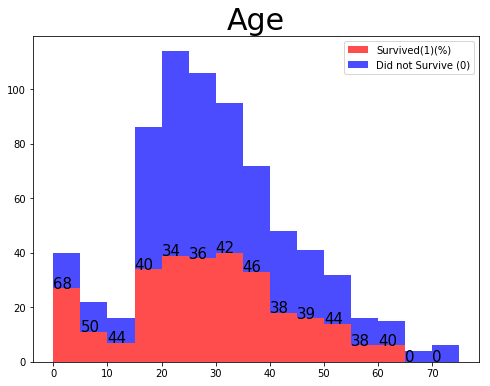

In [13]:
#Visualize the data by survivability

#first convert appropriate data into categorical
df['Sex'] = pd.Categorical(df['Sex'], ordered= False)
df['Embarked'] = pd.Categorical(df['Embarked'], ordered = False)
df['Pclass'] = pd.Categorical(df['Pclass'], ordered = False)
df['title'] = pd.Categorical(df['title'], ordered = False)

cols = ['Pclass','Sex','Embarked', 'isAlone', 'title']
for i in cols: 
    plt.rcParams['figure.figsize'] = [8, 6]
    classSurv = df.groupby('Survived')[i].value_counts().sort_index(level=1,sort_remaining = True)
    ax1 = plt.bar(classSurv[0].index,classSurv[0],color='b', alpha = 0.6, label='Did Not Survive(0)', bottom= classSurv[1],) 
    ax2 = plt.bar(classSurv[1].index,classSurv[1],color='r', alpha = 0.7, label='Survived(1) (%)') 
    if i == 'Pclass': 
        plt.xticks([1,2,3])
    elif i == 'isAlone':
        plt.xticks([0, 1])
    percSurv = (( classSurv[1] / (classSurv[1]+classSurv[0]) ) )*100
    percSurv = round(percSurv)
    rects = ax2.patches
    for rect, label in zip(rects, percSurv):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', color = 'k',size=15)
    plt.title(i,size = 30)
    plt.legend()
    plt.show()

#Create the plot to see % passengers survived based on family size 
famSurvSort = df.groupby('Survived')['familySize'].value_counts().sort_index(level=1,sort_remaining = True)
famSurv = famSurvSort[0]+ famSurvSort[1]
plt.bar(famSurv.index,famSurv, label = 'Did not Survive(0)',alpha = 0.6, color ='b')
ax3 = plt.bar(famSurvSort[1].index,famSurvSort[1],color='r', alpha = 0.7, label='Survived (1)(%)') 
percFam = round(famSurvSort[1] / famSurv * 100)
rects1 = ax3.patches
for rect1, label in zip(rects1, percFam):
    height = rect1.get_height()
    plt.text(rect1.get_x() + rect1.get_width() / 2, height + 5, label,
        ha='center', va='bottom', color = 'k',size=15)
plt.title('Family Size', size=30)
plt.legend()
plt.show()


#plt.figure()
#by gender
hist0, hist1 = df.groupby('Survived')['Age']
agebins = range(0,80,5)
ageSurv0 = hist0[1].values
ageSurv0 = ageSurv0[np.isfinite(ageSurv0)]
ageSurv1 = hist1[1].values[np.isfinite(hist1[1].values)]
[ax4,bins,patches] = plt.hist([ageSurv1, ageSurv0], bins= agebins, stacked = True, alpha = 0.7, 
         label=['Survived(1)(%)', 'Did not Survive (0)'],color=['r','b'])
#get the percentage
percAge0 = np.histogram(ageSurv0,agebins)
percAge1 = np.histogram(ageSurv1,agebins)
percSurv = np.round( (percAge1[0] / (percAge0[0]+percAge1[0]) * 100),0) 
#get the height of patches
for i in range(bins.shape[0]-1):
    plt.text(bins[i],ax4[0][i],int(percSurv[i]),color = 'k',size=15 )
#for rectA, label in zip(patches, percSurv):
#    height = rectA.get_height()
#    plt.text(rectA.get_x() + rectA.get_width() / 2, height + 5, label,
#        ha='center', va='bottom', color = 'k',size=15)
plt.legend()
plt.title('Age',size=30)
plt.show()

## 4. Correlation coefficients

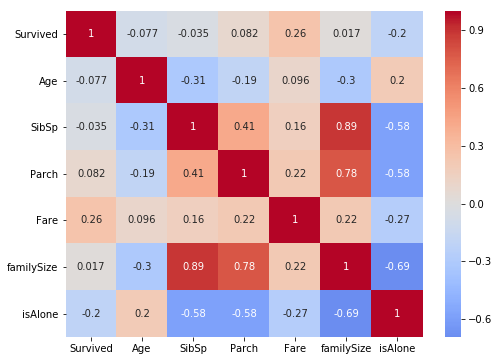

In [14]:
#get the correlation coefficients for the data
corrVals = df.corr(method='pearson')
plt.rcParams['figure.figsize'] = [8, 6]
sns.heatmap(corrVals, center = 0, cmap = 'coolwarm', annot = True)


#sns.pairplot(df, hue= 'Survived', size = 2.5)
#sns.factorplot('Survived','Age', data = df, kind = 'box')

## 5. Missing Data 
### options for filling:
 1. Remove those rows  (Ignoring this option)
 2. Impute the values using mean, median, mode
 3. Predict value using another model
 4. Insert random value (ignoring this option)

I will choose two of the options and compare the results to see which produces a better model.  The data description said that age was also estimated in some cases.  I will get a count to see how many of the passengers had an estimated age to make sure it isn't an overwhelming amount. 

Cabin has too many missing features and will be dropped from the data.  

Embarked has two missing data points and will be imputed with the mode.  

In [15]:
#impute embark with the mode:
modeEm = df['Embarked'].mode()
df['Embarked'] = df['Embarked'].fillna(modeEm[0])

#check to make sure impute works
assert( df['Embarked'].isnull().sum() == 0 )


In [16]:
# The age data is estimated if it ends in 0.5
# Count the number of estimated ages to see if it is large

#create list of ages and remove NaN
age_vals = df['Age'].dropna()

estimated_age = [i for i in age_vals if i - int(i) != 0]
print('The percentage of estimated ages in the dataset: ',str(len(estimated_age)/len(age_vals)),'%')

#This is a small number so we will ignore this

The percentage of estimated ages in the dataset:  0.0350140056022409 %


### a. Imputing mean age based on class,gender

In [17]:
#Explore the mean age per class, per gender
meanAge = df.groupby(['Sex','Pclass'])['Age'].mean()
print('Mean:')
print(meanAge)

df['Age_mean'] = df['Age']

#impute the mean based on class and gender
df['Age_mean'] = df['Age_mean'].fillna(df.groupby(['Sex','Pclass'])['Age_mean'].transform('mean'))

#verify NaN has been filled
assert( df['Age_mean'].isnull().sum() == 0 )


Mean:
Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64


### b. Estimating age using KNN

 Before running any models the categorical data needs to be converted using one hot encoder

In [18]:
#first I need to use one hot encoder to convert categorical data
##after I created this I discovered this could all be done with pd.get_dummies(df['Sex'])


#create function to convert categorical data into binary array
def catToBinary(X): 
    values = np.array(X)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(values[:10])
    #print(onehot_encoded[:10,:])
    #print(label_encoder.classes_)
    return label_encoder.classes_, onehot_encoded


#create function to make new features using one hot encoding
#input variable is the categorical feature, (df['Pclass'])
def createNewFeatures(catData, dataframe): 
    labels, encodedData = catToBinary(dataframe[catData])
    len(dataframe[catData].unique())
    assert( labels.shape[0] == len(dataframe[catData].unique() ) )
    for idx, item in enumerate(labels) : 
        #make new feature
        newFeatureName = (catData+str(item))
        #print(newFeatureName)
        dataframe[newFeatureName] = encodedData[:,idx]
        #print(idx)

catList = ['Pclass', 'Sex', 'Embarked', 'title' ]
for cat in catList: 
    createNewFeatures(cat, df)
df.columns

#I don't know if Sex should be two columns so I will featurize it too
#vectorizer = DictVectorizer( sparse = False )
#df['Sex'] = vectorizer.fit_transform( df['Sex'],[0,1])



Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'familySize', 'isAlone', 'title',
       'Age_mean', 'Pclass1', 'Pclass2', 'Pclass3', 'Sexfemale', 'Sexmale',
       'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'titleMaster.', 'titleMiss.',
       'titleMr.', 'titleMrs.', 'titleRare.'],
      dtype='object')

Now that we have all of the categorical data ready for modeling we can estimate the age using KNN

train size: (571, 12)
test size:  (143, 12)
Training Set Accuracy: 0.4135749652774283
CV Test Set Accuracy: 0.19100212800945615


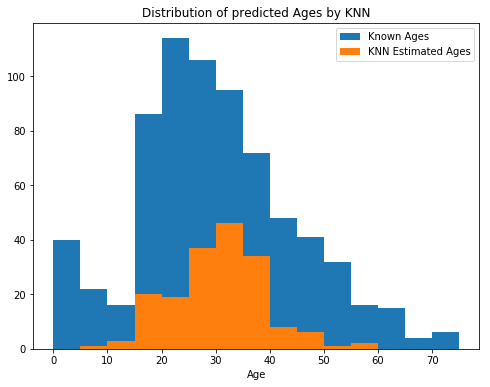

(177,)


In [19]:
#create new column
df['Age_KNN'] = df['Age']

#separate the data into null values
missVal = df['Age_KNN'].isnull()
nonNull = df['Age_KNN'].notnull()

varsKNN = ['SibSp','Parch','Fare',
    'Pclass2','Pclass3',
    'Sexfemale',
    'EmbarkedC','EmbarkedQ', 
    'titleMiss.','titleMr.','titleMrs.','titleRare.']

#create the x and y set 
xKNN = df[varsKNN][nonNull]
yKNN = df['Age_KNN'][nonNull]

#split into test and cross validation:
x_kNNtrain, x_kNNtest, y_kNNtrain, y_kNNtest = train_test_split(xKNN, yKNN, test_size=0.2)
print('train size:',x_kNNtrain.shape)
print('test size: ',x_kNNtest.shape)

#fit the data and predict the ages
knreg = KNeighborsRegressor()
knreg.fit(x_kNNtrain, y_kNNtrain)

predAge = knreg.predict(df[varsKNN][missVal])

print('Training Set Accuracy:',knreg.score(x_kNNtrain,y_kNNtrain))
print('CV Test Set Accuracy:',knreg.score(x_kNNtest,y_kNNtest))

#get the distribution of the predicted ages and compare to known ages
df['Age_KNN'][missVal] = predAge
plt.rcParams['figure.figsize'] = [8, 6]
plt.hist(age_vals,bins=range(0,80,5),label='Known Ages')
plt.hist(predAge,bins=range(0,80,5),label='KNN Estimated Ages')
plt.legend()
plt.xlabel('Age')
plt.title('Distribution of predicted Ages by KNN')
plt.show()

print(predAge.shape)


#R2 is a statistic that will give some information about the goodness of fit of a model. 
#In regression, the R2 coefficient of determination is a statistical measure of how well the 
#regression predictions approximate the real data points. An R2 of 1 indicates that 
#the regression predictions perfectly fit the data.

## Predict Survivors Using various Classifiers

In [47]:
#Get the data ready by splitting into test and train sets, feature scale 

#feature scale the age:
age_data = df['Age_mean'].values.reshape(-1, 1)
scaler = StandardScaler().fit(age_data)
print('Age:',scaler.mean_)
df['Age_scaled'] = scaler.transform(age_data)

#feature scale fare
fare_data = df['Fare'].values.reshape(-1, 1)
scalerF = StandardScaler().fit(fare_data)
print('Fare mean:',scalerF.mean_)
df['Fare_scaled'] = scaler.transform(fare_data)


#split data into test and train set
train, test = train_test_split(df, test_size=0.4, random_state = 22)
#skf = StratifiedKFold(n_splits=2)
#skf.get_n_splits(X, y)
print('train size:',train.shape)
print('test size: ',test.shape)

allvars = ['Survived','SibSp', 'Parch',
       'Fare', 'familySize', 'isAlone',
       'Age_mean', 'Pclass1', 'Pclass2', 'Pclass3', 'Sexfemale', 'Sexmale',
       'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'titleMaster.', 'titleMiss.',
       'titleMr.', 'titleMrs.', 'titleRare.', 'Age_KNN']

#choose the variables to use 
varSelect = ['Fare', 
    'Pclass1','Pclass2','Pclass3',
    'Sexfemale','Sexmale',
    'titleMr.','titleMiss.','titleMaster.','titleMrs.','titleRare.']

varSelectHot = ['Fare_scaled',
             'Age_scaled',
    'isAlone',
    'Pclass2','Pclass3',
    'Sexfemale',
    'EmbarkedC','EmbarkedQ',
    'titleMiss.','titleMaster.','titleMrs.','titleRare.']

y_train = train['Survived']
x_train = train[varSelect]

y_cvtest = test['Survived']
x_cvtest = test[varSelect]



Age: [29.31864272]
Fare mean: [32.20420797]
train size: (534, 31)
test size:  (357, 31)


### 1. Logistic Regression

In [29]:
 #Used LogRegCV from sklearn, which automatically selects best value of C

#using logistic regression from sklearn
def logisticReg(x,y): 
    logisticRegr = LogisticRegressionCV(max_iter = 15000)
    parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag')}
    grid = GridSearchCV(logisticRegr, parameters)
    grid.fit(x, y)
    
    # summarize the results of the grid search
    print('Best Score:', grid.best_score_)
    print('Best Estimator:', grid.best_estimator_.solver)

    return grid

def addpoly(x_train,y_train,x_cvtest,y_cvtest,poly_deg): 
    poly = PolynomialFeatures(poly_deg,include_bias=False)
    x_trainPoly = poly.fit_transform(x_train)
    x_testPoly = poly.fit_transform(x_cvtest)

    grid = logisticReg(x_trainPoly,y_train)
    
    return grid, x_trainPoly, x_testPoly, poly


poly_degree = range(1,4)

for i in poly_degree:
    print('Poly Degree:',i)
    grid, x_trainPoly, x_testPoly, poly = addpoly(x_train,y_train,x_cvtest,y_cvtest,i)
    
    kfold = model_selection.KFold(n_splits=20, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(LogisticRegressionCV(solver = grid.best_estimator_.solver), 
                                    poly.fit_transform(df[varSelect]), df['Survived'],
                                          cv=kfold, scoring=scoring)
    print("20-fold cross validation average accuracy: %.3f" % (results.mean()))
    
    print('Training Set Accuracy:',grid.score(x_trainPoly,y_train))
    print('CV Test Set Accuracy:',grid.score(x_testPoly,y_cvtest))
  

Poly Degree: 1
Best Score: 0.8170144462279294
Best Estimator: newton-cg
20-fold cross validation average accuracy: 0.790
Training Set Accuracy: 0.8394863563402889
CV Test Set Accuracy: 0.7574626865671642
Poly Degree: 2
Best Score: 0.8154093097913323
Best Estimator: newton-cg
20-fold cross validation average accuracy: 0.810
Training Set Accuracy: 0.8523274478330658
CV Test Set Accuracy: 0.7873134328358209


In [24]:
## Calculate the confustion matrix and the precision/recall

def confusionMatrix(model): 
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(x_cvtest)

    confusion_matrix = confusion_matrix(y_cvtest, y_pred)
    print('True Negative, False Positive')
    print(confusion_matrix)
    print('False Negative, True Positive')
    print()

    from sklearn.metrics import classification_report

    print(classification_report(y_cvtest, y_pred))

#precision = true pos/true pos+false pos
#recall is the ability of the classifier to find all the positive samples. tp/tp+fn

### 2. SVM 

In [30]:
svc_model = SVC()
parameter_candidates = {'kernel':('linear', 'sigmoid'), 'C' : [1,10, 100]}
gridSVC = GridSearchCV(svc_model, parameter_candidates)
gridSVC.fit(x_train, y_train)

# summarize the results of the grid search
print(gridSVC.best_score_)
print(gridSVC.best_estimator_.kernel)
print(gridSVC.best_estimator_.C)
print('CV Test Set Accuracy:',gridSVC.score(x_cvtest,y_cvtest))


kfold = model_selection.KFold(n_splits=20, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(SVC(kernel= str(gridSVC.best_estimator_.kernel), 
                C = gridSVC.best_estimator_.C), df[varSelect], df['Survived'],
                cv=kfold, scoring=scoring)
print("20-fold cross validation average accuracy: %.3f" % (results.mean()))

0.8186195826645265
linear
1
CV Test Set Accuracy: 0.7350746268656716
20-fold cross validation average accuracy: 0.791


### 3. Random Forest

In [48]:
#With the low score for logistic regression moved on to Random Forest based on suggestion online
random_forest = RandomForestClassifier(oob_score = True, bootstrap = True, max_features = len(varSelect)) 
parameter_cands = {'max_depth': [10, 20, 40, None],
 'min_samples_leaf': [1, 2, 4, 10],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [200, 300, 400],  
            }
gridRF = GridSearchCV(random_forest, parameter_cands)
#gridRF.fit(df[varSelect], df['Survived'])
gridRF.fit(x_train,y_train)

# summarize the results of the grid search
print('Best Score:', gridRF.best_score_)
print('Best Estimator:', gridRF.best_estimator_.n_estimators)
print('max_depth', gridRF.best_estimator_.max_depth)
print('min_samples_leaf', gridRF.best_estimator_.min_samples_leaf)
print('min_samples_split', gridRF.best_estimator_.min_samples_split)


#print('Training Set Accuracy:',gridRF.score(x_train, y_train))
#print('CV Test Set Accuracy:',gridRF.score(x_cvtest,y_cvtest))

Best Score: 0.8558052434456929
Best Estimator: 200
max_depth 10
min_samples_leaf 4
min_samples_split 10


In [49]:
random_forestT = RandomForestClassifier( 
    max_depth = gridRF.best_estimator_.max_depth,
     min_samples_leaf = gridRF.best_estimator_.min_samples_leaf,
     min_samples_split = gridRF.best_estimator_.min_samples_split,
     n_estimators = gridRF.best_estimator_.n_estimators,  
        max_features = len(varSelect) 
        ) 

random_forestT.fit(x_train, y_train)


print(random_forestT.feature_importances_)

print('CV Test Set Accuracy:',random_forestT.score(x_cvtest,y_cvtest))

kfold = model_selection.KFold(n_splits=20, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(random_forestT, df[varSelect], df['Survived'],
                cv=kfold, scoring=scoring)
print("20-fold cross validation average accuracy: %.3f" % (results.mean()))

[0.28620263 0.02424507 0.00389491 0.09457733 0.09673281 0.07644003
 0.35202933 0.00542523 0.01418459 0.00167255 0.04459553]
CV Test Set Accuracy: 0.8151260504201681
20-fold cross validation average accuracy: 0.855


### 4. Neural Network

In [32]:
clf = MLPClassifier()
parameterNN = {'solver': ('lbfgs', 'sgd', 'adam' ),
 'alpha': [0.0001, 0.001],
 'hidden_layer_sizes': [100, 200, 300],
 'max_iter': [300, 400], 
  'activation': ('logistic', 'relu')                }
gridNN = GridSearchCV(clf, parameterNN)
gridNN.fit(x_train, y_train)

print('Best Score:', gridNN.best_score_)
print('Best Solver:', gridNN.best_estimator_.solver)
print('alpha', gridNN.best_estimator_.alpha)
print('hidden_layer_sizes', gridNN.best_estimator_.hidden_layer_sizes)
print('max_iter', gridNN.best_estimator_.max_iter)
print('activation', gridNN.best_estimator_.activation)

#print('Training Set Accuracy:',clf.score(x_train,y_train))
print('CV Test Set Accuracy:',gridNN.score(x_cvtest,y_cvtest))


Best Score: 0.8170144462279294
Best Solver: adam
alpha 0.001
hidden_layer_sizes 100
max_iter 400
activation relu
CV Test Set Accuracy: 0.7873134328358209


In [ ]:
clfN = MLPClassifier(
solver = gridNN.best_estimator_.solver,
alpha =  gridNN.best_estimator_.alpha,
hidden_layer_sizes =  gridNN.best_estimator_.hidden_layer_sizes,
max_iter =  gridNN.best_estimator_.max_iter, 
activation = str(gridNN.best_estimator_.activation)    
)

clfN.fit(x_train, y_train)

kfold = model_selection.KFold(n_splits=20, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(clfN, df[varSelectHot], df['Survived'],
                cv=kfold, scoring=scoring)
print("20-fold cross validation average accuracy: %.3f" % (results.mean()))

## Run Model for Contest

In [42]:
kaggle_df = pd.read_csv('~/Documents/Data_Science_Training/Kaggle_Projects/Titanic/test.csv',)
print(kaggle_df.shape)

#change index to passengerId
kaggle_df = kaggle_df.set_index('PassengerId')

kaggle_df.head()
#Count the number of missing values in the dataset
print(kaggle_df.isnull().sum())


(418, 11)
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


### Do the same feature modification

In [43]:
createFamSize(kaggle_df)
createIsAlone(kaggle_df)
createTitle(kaggle_df)

#impute embark with the mode:
meanFare = kaggle_df['Fare'].mean()
kaggle_df['Fare'] = kaggle_df['Fare'].fillna(meanFare)

#check to make sure impute works
assert( kaggle_df['Fare'].isnull().sum() == 0 )

kaggle_df['Age_mean'] = kaggle_df['Age']

#impute the mean based on class and gender
kaggle_df['Age_mean'] = kaggle_df['Age_mean'].fillna(kaggle_df.groupby(['Sex','Pclass'])['Age_mean'].transform('mean'))

#verify NaN has been filled
assert( kaggle_df['Age_mean'].isnull().sum() == 0 )


Mr.        240
Miss.       79
Mrs.        72
Master.     21
Rare.        6
Name: title, dtype: int64


In [44]:
kcatList = ['Pclass', 'Sex', 'Embarked', 'title' ]
for kcat in kcatList: 
    createNewFeatures(kcat, kaggle_df)

kaggle_df.head()



,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,Sexfemale,Sexmale,EmbarkedC,EmbarkedQ,EmbarkedS,titleMaster.,titleMiss.,titleMr.,titleMrs.,titleRare.
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [50]:
#make predictions with my random forest trained above

pred = random_forestT.predict(kaggle_df[varSelect])
print(pred)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 1]


In [51]:
ksubmission = pd.DataFrame({
        "Survived": pred
    }, index = kaggle_df.index)
ksubmission.head()

ksubmission.to_csv('titanic.csv')
print('Exported')

Exported
